In [144]:
#%pip install --upgrade "fsspec>=2024.2.0" "s3fs>=2024.2.0" "xarray>=2024.1.0" "kerchunk>=0.2.6"

In [1]:
import fsspec
import logging, os
from dask.distributed import Client, progress
from kerchunk.hdf import SingleHdf5ToZarr
from kerchunk.combine import MultiZarrToZarr
import ujson, re, xarray as xr
for name in ["kerchunk","fsspec", "s3fs", "botocore", "aiobotocore", "s3fs.core","zarr","matplotlib"]:
    logging.getLogger(name).setLevel(logging.WARNING)

In [2]:
tas_ref = "/home/a1r/git/spear_refs/tas_ensemble_refs.json"

In [3]:
if (not os.path.exists(tas_ref)):
   print("We need to create the reference")
else:
    print("Reference json exists")

Reference json exists


In [33]:
#%pip install dask-gateway dask-gateway-server

In [4]:
from dask.distributed import Client
import dask

# Connect to your running cluster
# (if you started it via JupyterLab’s Dask panel, copy its address)
client = Client("tcp://127.0.0.1:42025")  # replace with your scheduler address
client

# Make this client the global default
dask.config.set(scheduler="distributed")

print(f"Dask dashboard: {client.dashboard_link}")

def check_dask():
    print("Scheduler:", dask.config.get("scheduler"))
    print("Client:", client)
    print("Workers:", len(client.scheduler_info()['workers']))
    print("Threads per worker:", [w['nthreads'] for w in client.scheduler_info()['workers'].values()])

check_dask()

Dask dashboard: http://127.0.0.1:45395/status
Scheduler: distributed
Client: <Client: 'tcp://127.0.0.1:42025' processes=10 threads=30, memory=470.94 GiB>
Workers: 10
Threads per worker: [3, 3, 3, 3, 3, 3, 3, 3, 3, 3]


In [43]:
import s3fs
import re

def get_run_sorted_files(variable="tas", bucket="noaa-gfdl-spear-large-ensembles-pds"):
    """
    Return a list of S3 URLs for a given variable (tas, pr, etc.)
    from the NOAA GFDL-SPEAR-MED historical ensemble, sorted by r* member number.
    """
    fs = s3fs.S3FileSystem(anon=True)

    prefix = "SPEAR/GFDL-LARGE-ENSEMBLES/CMIP/NOAA-GFDL/GFDL-SPEAR-MED/historical/"
    all_keys = fs.find(f"{bucket}/{prefix}")

    
    # Filter only matching variable NetCDFs
  #  files = [f"s3://{k}" for k in all_keys if f"/Amon/{variable}/" in k and k.endswith(".nc")]
    #files = [f"s3://{bucket}/{k}" for k in all_keys if f"/Amon/{variable}/" in k and k.endswith(".nc")]
    files = [f"s3://{k}" for k in all_keys if f"/Amon/{variable}/" in k and k.endswith(".nc")]

    # Sort by ensemble member r*
    def run_sort_key(path):
        fname = path.split("/")[-1]
        match = re.search(r"r(\d+)i", fname)
        return int(match.group(1)) if match else 9999

    return sorted(files, key=run_sort_key)

In [26]:
if(not os.path.exists(tas_ref)):
  tas_files = get_run_sorted_files("tas")
  #print(len(tas_files), "tas files")
  print(tas_files[:1])

['s3://noaa-gfdl-spear-large-ensembles-pds/SPEAR/GFDL-LARGE-ENSEMBLES/CMIP/NOAA-GFDL/GFDL-SPEAR-MED/historical/r1i1p1f1/Amon/tas/gr3/v20210201/tas_Amon_GFDL-SPEAR-MED_historical_r1i1p1f1_gr3_192101-201412.nc']


In [55]:
import nest_asyncio
nest_asyncio.apply()
# ---------------------------------------------------------------------
#  Dask-parallel kerchunk: translate each NetCDF → reference dict
# ---------------------------------------------------------------------
def build_ref(url):
    so = {"anon": True,"asynchronous": False}
    with fsspec.open(url, **so) as infile:
        h5chunks = SingleHdf5ToZarr(infile, url, inline_threshold=300)
        return h5chunks.translate()

if( os.path.exists(tas_ref)):
  futures = client.map(build_ref, tas_files)
  refs = client.gather(futures)   # collect results
  print(f"Kerchunked {len(refs)} members") 

Kerchunked 30 members


In [149]:
#%pip install ipywidgets

In [46]:
#from dask.distributed import progress
#future = ds['tas'].mean(dim='member').persist()
#progress(future)
print((client.dashboard_link))

http://127.0.0.1:45395/status


In [58]:
if (not os.path.exists(tas_ref)):
    import nest_asyncio
    nest_asyncio.apply()

# ---------------------------------------------------------------------
# Combine references across members (MultiZarrToZarr)
# ---------------------------------------------------------------------
# Attach "member" dimension for each ref

    for i, ref in enumerate(refs, start=1):
        ref["refs"]["member"] = f"r{i}i1p1f1"

    mzz = MultiZarrToZarr(
        refs,
        #
        remote_protocol="s3",
        remote_options={"anon": True, "asynchronous": False},
        #
        concat_dims=["member"],     # stack along member
        coo_map={"member": [f"r{i}i1p1f1" for i in range(1, 31)]}
    )
    combined = mzz.translate()

    # Save combined ref  
    with open("tas_ensemble_refs.json", "w") as f:
        ujson.dump(combined, f)

In [5]:
import xarray as xr
import logging

# Assuming 'my_local_reference.json' is the path to your locally saved Kerchunk reference file
# and the original data chunks are stored in an S3 bucket.

ds = xr.open_dataset(
    "reference://",
    engine="zarr",
    chunks={},
    backend_kwargs={
        "consolidated": False,  # Set to True if your reference file is consolidated
        "storage_options": {
            "fo": tas_ref,  # Path to your local reference file
            "remote_protocol": "s3",        # Protocol for the remote data source
            "remote_options": {"anon": True,"asynchronous": True}, # Options for S3 access (e.g., anonymous access)
            "asynchronous": True
        }
    }
)

In [63]:
#type(ds['tas'].data)# numpy or dask.array 
#ds['tas']
print(type(ds['tas'].data))

<class 'dask.array.core.Array'>


In [6]:
ds

<xarray.Dataset> Size: 28GB
Dimensions:    (member: 30, lat: 360, bnds: 2, lon: 576, time: 1128)
Coordinates:
  * member     (member) object 240B 'r10i1p1f1' 'r11i1p1f1' ... 'r9i1p1f1'
  * bnds       (bnds) float64 16B 1.0 2.0
  * lat        (lat) float64 3kB -89.75 -89.25 -88.75 ... 88.75 89.25 89.75
  * lon        (lon) float64 5kB 0.3125 0.9375 1.562 2.188 ... 358.4 359.1 359.7
  * time       (time) object 9kB 1921-01-16 12:00:00 ... 2014-12-16 12:00:00
Data variables:
    lat_bnds   (member, lat, bnds) float64 173kB dask.array<chunksize=(1, 360, 2), meta=np.ndarray>
    lon_bnds   (member, lon, bnds) float64 276kB dask.array<chunksize=(1, 576, 2), meta=np.ndarray>
    tas        (member, time, lat, lon) float32 28GB dask.array<chunksize=(1, 1, 360, 576), meta=np.ndarray>
    time_bnds  (member, time, bnds) object 541kB dask.array<chunksize=(1, 1, 2), meta=np.ndarray>
Attributes: (12/28)
    history:                File was processed by fremetar (GFDL analog of CM...
    table_id:               Amon
    contact:                gfdl.climate.model.info@noaa.gov
    experiment:             all-forcing simulation for 1921 to 2014
    experiment_id:          historical
    Conventions:            CF-1.7
    ...                     ...
    references:             SPEAR: The next generation GFDL modeling system f...
    title:                  NOAA GFDL GFDL-SPEAR-MED, all-forcing simulation ...
    gfdl_experiment_name:   SPEAR-MED.historical.r1
    license:                CC-BY-SA-4.0
    forcing:                CMIP6 historical
    external_variables:     areacella

Total computation time: 56.55 seconds


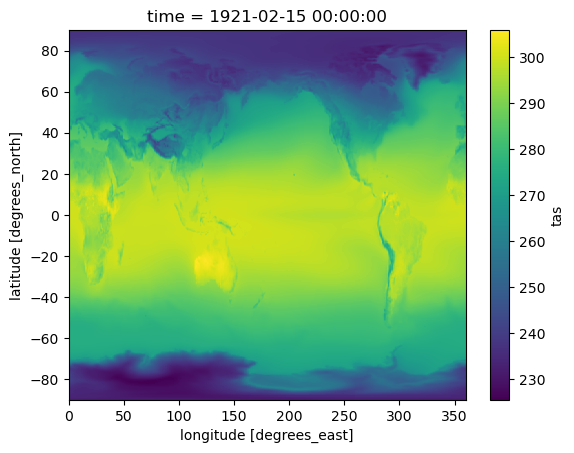

In [8]:
start_time = time.time()
tas_mean = ds['tas'].isel(time=1).mean(dim='member')
tas_mean.plot()
end_time = time.time()
print(f"Total computation time: {end_time - start_time:.2f} seconds")

In [156]:
#time mean (across all time steps)
#time_mean = ds['tas'].mean(dim='time')#This gives a spatial field (member, lat, lon) showing each member’s climatological mean.

In [157]:
#time_mean.mean(dim='member').plot(cmap='coolwarm')
#plt.title("Ensemble mean of time-mean temperature")

In [158]:
# ensemble mean of time 
#To compute the climatological ensemble mean (1 number per grid point):

In [9]:
import time
start_time = time.time()
#The long-term average temperature at each grid cell, averaged across all members — a climatological map of mean state.
#A spatial climatology map showing the long-term mean temperature pattern, 
#averaged across all ensemble members.
#Removes both the time variability and ensemble variability  
ens_time_mean = ds['tas'].mean(dim=('member', 'time'))#.compute()
ens_time_mean.compute()


<xarray.DataArray 'tas' (lat: 360, lon: 576)> Size: 829kB
array([[223.87544, 223.8699 , 223.86436, ..., 223.89204, 223.8865 ,
        223.88097],
       [224.65929, 224.6497 , 224.6401 , ..., 224.68777, 224.6783 ,
        224.6688 ],
       [225.55467, 225.54129, 225.5279 , ..., 225.59468, 225.58138,
        225.56802],
       ...,
       [254.10645, 254.11058, 254.11469, ..., 254.09406, 254.09819,
        254.10234],
       [254.05727, 254.05922, 254.0612 , ..., 254.05136, 254.05331,
        254.05531],
       [253.96732, 253.96797, 253.96855, ..., 253.96548, 253.96611,
        253.96672]], dtype=float32)
Coordinates:
  * lat      (lat) float64 3kB -89.75 -89.25 -88.75 -88.25 ... 88.75 89.25 89.75
  * lon      (lon) float64 5kB 0.3125 0.9375 1.562 2.188 ... 358.4 359.1 359.7

In [ ]:
ens_time_mean.plot()
end_time = time.time()
print(f"Total computation time: {end_time - start_time:.2f} seconds")

In [ ]:
#global mean 
#A time series of the global (lat-lon) mean temperature anomaly or absolute value.
#Each point is a global mean at a particular time, averaged across ensemble members.
#The average evolution of the Earth’s global temperature over time, combining all ensemble members.
import time
import numpy as np
start_time = time.time()
weights = np.cos(np.deg2rad(ds['lat']))
tas_weighted = ds['tas'] * weights
global_mean = tas_weighted.mean(dim=('member', 'lat', 'lon'))
global_mean.plot()
#plt.title("Global mean ensemble temperature")
end_time = time.time()
print(f"Total computation time: {end_time - start_time:.2f} seconds")

In [ ]:
#%pip install -U "s3fs>=2024.2.0" "fsspec>=2024.2.0" "boto3>=1.34"

| Diagnostic                  | Dimensions kept      | QC insight                               |
| --------------------------- | -------------------- | ---------------------------------------- |
| **Ensemble + Time Mean**    | `(lat, lon)`         | Detect spatial/unit/metadata errors      |
| **Global Mean Time Series** | `(time)`             | Detect temporal/drift/integration errors |
| **Std across time**         | `(member, lat, lon)` | Detect noisy or flat members             |
| **Std across members**      | `(time, lat, lon)`   | Detect member divergence                 |
